# Extract coastal waterlines across time
**What does this notebook do?** 

This notebooks demonstrates how to tidally tag remotely sensed imagery using the [OSU Tidal Prediction Software or OTPS](http://volkov.oce.orst.edu/tides/otps.html) model, create geomedian composites for a given set of epochs and tidal range, and extract waterline contours from the composite layers for each epoch. 

**Requirements:** 

You need to run the following commands from the command line prior to launching jupyter notebooks from the same terminal so that the required libraries and paths are set:

`module use /g/data/v10/public/modules/modulefiles` 

`module load dea/20180515`  *(currently using an older version of `dea` due to a bug in `xr.concat`; will be reverted to `module load dea` in future)*

`module load otps`

If you find an error or bug in this notebook, please either create an 'Issue' in the Github repository, or fix it yourself and create a 'Pull' request to contribute the updated notebook back into the repository (See the repository [README](https://github.com/GeoscienceAustralia/dea-notebooks/blob/master/README.rst) for instructions on creating a Pull request).

**Date:** September 2018

**Author:** Robbi Bishop-Taylor

## Import modules

In [264]:
import os
import sys
import datacube
import itertools
import warnings
import numpy as np
import xarray as xr
import pandas as pd
import geopandas as gpd
from otps import TimePoint
from otps import predict_tide
from datetime import datetime, timedelta
from datacube.utils import geometry
from datacube.utils.geometry import CRS
from datacube_stats.statistics import GeoMedian
from dateutil.relativedelta import relativedelta
from datacube.helpers import ga_pq_fuser
from datacube.helpers import write_geotiff
from datacube.storage import masking
from shapely.geometry import Point
from collections import defaultdict
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

sys.path.append('../10_Scripts')
import SpatialTools, DEAPlotting

# For nicer notebook plotting, hide warnings (comment out for real analysis)
warnings.filterwarnings('ignore') 

# Create datacube instance
dc = datacube.Datacube(app='Tidal geomedian filmstrips')

def date_range(start_date, end_date, increment, period):
    
    """Generate dates seperated by given time increment/period"""
    
    result = []
    nxt = start_date
    delta = relativedelta(**{period:increment})
    while nxt <= end_date:
        result.append(nxt)
        nxt += delta
    return result

def ds_to_rgb(ds, bands=['red', 'green', 'blue'], reflect_stand=4000):
    
    """Converts an xarray dataset to a three band array"""
    
    rawimg = np.transpose(ds[bands].to_array().data, [1, 2, 0])
    img_toshow = (rawimg / reflect_stand).clip(0, 1)
    return img_toshow


../10_Scripts/DEAPlotting.py:24: UserWarning: matplotlib.pyplot as already been imported, this call will have no effect.
  matplotlib.use('agg')


## Geomedian filmstrip parameters
Set the area, time period  and sensors of interest, and tide limits and epoch length used to produce each geomedian composite. This is the only cell that needs to be edited to run the notebook.

In [730]:
# # Set up centre of study area and buffer size in metres for data extraction
# study_area = 'pointstuart_wide'  # name used as prefix for output files
# lat, lon = -12.238, 131.849  # centre of study area
# buffer = 15000  # metre units to extend region of interest on each side of centre point

# # Set up centre of study area and buffer size in metres for data extraction
# study_area = 'mitchell'  # name used as prefix for output files
# lat, lon = -15.14995, 141.63650  # centre of study area
# buffer = 10000  # metre units to extend region of interest on each side of centre point

# # Set up centre of study area and buffer size in metres for data extraction
# study_area = 'inskip'  # name used as prefix for output files
# lat, lon = -25.7909598625, 153.073231901  # centre of study area
# buffer = 8000  # metre units to extend region of interest on each side of centre point

# Set up centre of study area and buffer size in metres for data extraction
study_area = 'narrabeen'  # name used as prefix for output files
lat, lon = -33.72, 151.3006  # centre of study area
buffer = 2000  # metre units to extend region of interest on each side of centre point

# # Set up centre of study area and buffer size in metres for data extraction
# study_area = 'victoriariver_2yr'  # name used as prefix for output files
# lat, lon = -15.4440342949, 129.811912341  # centre of study area
# buffer = 8000  # metre units to extend region of interest on each side of centre point

# # Set up centre of study area and buffer size in metres for data extraction
# study_area = 'victoriariver2_2yr'  # name used as prefix for output files
# lat, lon = -15.4475061785, 130.128534164  # centre of study area
# buffer = 8000  # metre units to extend region of interest on each side of centre point

# # Set up centre of study area and buffer size in metres for data extraction
# study_area = 'ard_test_comp'  # name used as prefix for output files
# lat, lon = -19.4889944734, 147.507306961  # centre of study area
# buffer = 10800  # metre units to extend region of interest on each side of centre point

# # Set up centre of study area and buffer size in metres for data extraction
# study_area = 'kingashbaylarge'  # name used as prefix for output files
# lat, lon = -15.913720, 136.494590  # centre of study area
# buffer = 10000  # metre units to extend region of interest on each side of centre point

# Set up compositing parameters
time_period = ('1987-01-01', '2019-01-01')  # Total date range to import data from
sensors = ['ls5', 'ls7', 'ls8']  # Landsat sensors from which to import data from
ls7_slc_off = True  # Whether to include striped > May 31 2003 Landsat 7 SLC-off data
lower_tideheight = 0.0 # Minimum proportion of the observed tidal range to include 
upper_tideheight = 1.0  # Maximum proportion of the observed tidal range to include 
epoch_years = 1  # Length of each epoch used to compute geomedians (i.e. 5 years = 1988 to 1993)


## Return observations for each sensor for the entire time series
Use `dask` to lazily load Landsat data and PQ for each sensor for the entire time series. No data is actually loaded here: this is saved until after the layers have been filtered by tidal stage and date to save processing time.

In [731]:
# If output data and figure directories doesn't exist, create them
if not os.path.isdir('output_data/{}/'.format(study_area)):
    os.makedirs('output_data/{}/'.format(study_area))
    
if not os.path.isdir('figures/{}/'.format(study_area)):
    os.makedirs('figures/{}/'.format(study_area))

# Create list of epochs between start and end of time_period in datetime format
start = datetime.strptime(time_period[0], '%Y-%m-%d')
end = datetime.strptime(time_period[1], '%Y-%m-%d')
epochs = date_range(start, end, epoch_years, 'years')

# Print list of epochs
epochs_strings = [epoch.strftime('%Y-%m-%d') for epoch in epochs][:-1]
print('Processing {} epochs: {}'.format(len(epochs_strings), ', '.join(epochs_strings)))

# # Identify tide point by importing ITEM polygons
# polygons_gpd = gpd.read_file('/g/data/r78/intertidal/GA_native_tidal_model.shp')
# polygon_gpd = polygons_gpd[polygons_gpd.intersects(Point(lon, lat))]
# tidepost_lon, tidepost_lat = polygon_gpd[['lon', 'lat']].values[0]
tidepost_lat, tidepost_lon  = lat, lon
print('Using tidepost coordinates: {} E, {} S\n'.format(tidepost_lon, tidepost_lat))

# Set up query
x, y = geometry.point(lon, lat, CRS('WGS84')).to_crs(CRS('EPSG:3577')).points[0]
query = {'x': (x - buffer, x + buffer),
         'y': (y - buffer, y + buffer),
         'time': time_period,
         'crs': 'EPSG:3577'}

# Output dicts to hold entire time-series for each sensor
sensor_dict = {}
pq_dict = {}

# For each sensor, dask load data and compute tide heights for each sensor
for sensor in sensors:
    
    # The following code will fail if there is no data for the sensor in time_period;
    # this try statement catches this and skips the affected sensor    
    try:
    
        # Return observations matching query without actually loading them using dask
        sensor_all = dc.load(product = '{}_nbart_albers'.format(sensor), 
                         group_by = 'solar_day', 
                         measurements = ['blue', 'green', 'nir', 'swir1', 'swir2'],
                         dask_chunks={'time': 1},
                         **query)

        # Load PQ data matching query without actually loading them using dask
        pq_all = dc.load(product = '{}_pq_albers'.format(sensor),
                        group_by = 'solar_day',
                        fuse_func=ga_pq_fuser, 
                        dask_chunks={'time': 1},
                        **query)
        
        # Remove Landsat 7 SLC-off from PQ layer if ls7_slc_off = False
        if not ls7_slc_off and sensor == 'ls7':
            sensor_all = sensor_all.where(sensor_all.time < np.datetime64('2003-05-30'), drop=True) 

        # Use the tidal mode to compute tide heights for each observation:
        print('Computing tidal heights for {} {} observations'.format(len(sensor_all.time), sensor))
        obs_datetimes = sensor_all.time.data.astype('M8[s]').astype('O').tolist()
        obs_timepoints = [TimePoint(tidepost_lon, tidepost_lat, dt) for dt in obs_datetimes]
        obs_predictedtides = predict_tide(obs_timepoints)
        obs_tideheights = [predictedtide.tide_m for predictedtide in obs_predictedtides]

        # Assign tide heights to the dataset as a new variable
        sensor_all['tide_heights'] = xr.DataArray(obs_tideheights, [('time', sensor_all.time)]) 

        # Append results for each sensor to a dictionary with sensor name as the key
        sensor_dict[sensor] = sensor_all
        pq_dict[sensor] = pq_all 
    
    except AttributeError:
        
        print('{} selection failed due to likely lack of data in time_period; skipping'.format(sensor))

Processing 32 epochs: 1987-01-01, 1988-01-01, 1989-01-01, 1990-01-01, 1991-01-01, 1992-01-01, 1993-01-01, 1994-01-01, 1995-01-01, 1996-01-01, 1997-01-01, 1998-01-01, 1999-01-01, 2000-01-01, 2001-01-01, 2002-01-01, 2003-01-01, 2004-01-01, 2005-01-01, 2006-01-01, 2007-01-01, 2008-01-01, 2009-01-01, 2010-01-01, 2011-01-01, 2012-01-01, 2013-01-01, 2014-01-01, 2015-01-01, 2016-01-01, 2017-01-01, 2018-01-01
Using tidepost coordinates: 151.3006 E, -33.72 S

Computing tidal heights for 314 ls5 observations
Computing tidal heights for 336 ls7 observations
Computing tidal heights for 125 ls8 observations


## Subset data by tidal height and epoch time range
Use image time-stamps to compute tidal heights at the time of each observation, and take a subset of the entire Landsat and PQ time series based on tide height and epoch date range for each sensor.

In [732]:
# If any sensor has 0 observations, remove it from the dictionary before proceeding
sensor_dict = {key:value for key, value in sensor_dict.items() if len(value.time) > 0}

# Calculate max and min tide heights for the entire time series and all sensors
obs_min = np.min([sensor_ds.tide_heights.min() for sensor_ds in sensor_dict.values()])
obs_max = np.max([sensor_ds.tide_heights.max() for sensor_ds in sensor_dict.values()])
obs_range = obs_max - obs_min

# Calculate tidal limits used for subsequent data selection
sel_min = obs_min + (obs_range * lower_tideheight)
sel_max = obs_min + (obs_range * upper_tideheight)
print('Keeping tidal heights of {0:.2f} m to {1:.2f} m out of an observed local tidal ' 
      'range of {2:.2f} m to {3:.2f} m'.format(sel_min, sel_max, obs_min, obs_max))

# Create dictionaries to hold filtered sensor data for each epoch
sensor_epoch_dict = defaultdict(list)
pq_epoch_dict = defaultdict(list)
   
for epoch, sensor in itertools.product(epochs[:-1], sensor_dict.keys()):
                                           
    # Select dataset
    sensor_all = sensor_dict[sensor]  
    pq_all = pq_dict[sensor] 
    
    # Filter to keep only observations that have matching PQ data 
    time = (sensor_all.time - pq_all.time).time
    sensor_subset = sensor_all.sel(time=time)
    pq_subset = pq_all.sel(time=time)
                                           
    # Filter by tidal stage
    sensor_subset = sensor_subset.where((sensor_subset.tide_heights >= sel_min) &
                                        (sensor_subset.tide_heights <= sel_max), drop = True)
    
    # Filter pq to same timesteps (this avoids conversion to float by `.where`)
    pq_subset = pq_subset.sel(time = sensor_subset.time)

    # Identify from and to date strings
    from_date = epoch.strftime('%Y-%m-%d')
    to_date = (epoch + relativedelta(years=epoch_years)).strftime('%Y-%m-%d')
    
    # Subset sensor to from and to date for epoch
    print('    Filtering from {} to {} for {}'.format(from_date, to_date, sensor))
    sensor_subset = sensor_subset.sel(time=slice(from_date, to_date))
    pq_subset = pq_subset.sel(time=slice(from_date, to_date))

    # Add subsetted data to dicts (one key matching a list of sensor data for each epoch)
    sensor_epoch_dict[from_date].append(sensor_subset)
    pq_epoch_dict[from_date].append(pq_subset)
    

Keeping tidal heights of -0.62 m to 1.04 m out of an observed local tidal range of -0.62 m to 1.04 m
    Filtering from 1987-01-01 to 1988-01-01 for ls5
    Filtering from 1987-01-01 to 1988-01-01 for ls7
    Filtering from 1987-01-01 to 1988-01-01 for ls8
    Filtering from 1988-01-01 to 1989-01-01 for ls5
    Filtering from 1988-01-01 to 1989-01-01 for ls7
    Filtering from 1988-01-01 to 1989-01-01 for ls8
    Filtering from 1989-01-01 to 1990-01-01 for ls5
    Filtering from 1989-01-01 to 1990-01-01 for ls7
    Filtering from 1989-01-01 to 1990-01-01 for ls8
    Filtering from 1990-01-01 to 1991-01-01 for ls5
    Filtering from 1990-01-01 to 1991-01-01 for ls7
    Filtering from 1990-01-01 to 1991-01-01 for ls8
    Filtering from 1991-01-01 to 1992-01-01 for ls5
    Filtering from 1991-01-01 to 1992-01-01 for ls7
    Filtering from 1991-01-01 to 1992-01-01 for ls8
    Filtering from 1992-01-01 to 1993-01-01 for ls5
    Filtering from 1992-01-01 to 1993-01-01 for ls7
    Filtering f

## Combine multiple sensors, load data and generate geomedians
For each epoch, combine all sensors into one dataset, load the data for the first time using `dask`'s `.compute()`, then composite all timesteps into a single array using a geometric median computation.

In [734]:
# Dict to hold output geomedian composites
ndwi_dict = {}
mndwi_dict = {}
awei_ns_dict = {}
awei_s_dict = {}
tideheights_dict = {}

for from_date in sensor_epoch_dict.keys():
    
    # For the first time, actually load data for all sensors and then combine into one dataset  
    print('Loading and combining {} data for {}'.format(", ".join(sensor_dict.keys()), from_date))
    sensor_combined = xr.concat([i.compute() for i in sensor_epoch_dict[from_date]], dim='time')
    pq_combined = xr.concat([i.compute() for i in pq_epoch_dict[from_date]], dim='time')
    print('    {} observations combined'.format(len(sensor_combined.time)))
    
    # Manually add flag definition back in (it is lost during the concatenation)
    pq_combined.pixelquality.attrs['flags_definition'] = pq_all.pixelquality.flags_definition
    
    # Sort output datasets by date
    sensor_combined = sensor_combined.sortby('time')
    pq_combined = pq_combined.sortby('time')
    
    # Identify pixels with no clouds/shadows in either ACCA for Fmask
    good_quality = masking.make_mask(pq_combined.pixelquality,
                                     cloud_acca='no_cloud',
                                     cloud_shadow_acca='no_cloud_shadow',
                                     cloud_shadow_fmask='no_cloud_shadow',
                                     cloud_fmask='no_cloud',
                                     blue_saturated=False,
                                     green_saturated=False,
                                     red_saturated=False,
                                     nir_saturated=False,
                                     swir1_saturated=False,
                                     swir2_saturated=False,
                                     contiguous=True)
    
    # Apply mask to set all PQ-affected pixels to NaN and set nodata to NaN
    print('    Applying PQ mask and setting nodata to NaN')
    sensor_combined = sensor_combined.where(good_quality)
    sensor_combined = masking.mask_invalid_data(sensor_combined)
    
    # Compute NDWI
    sensor_combined["ndwi"] = (sensor_combined.green - sensor_combined.nir) / (sensor_combined.green + sensor_combined.nir)
    sensor_combined["mndwi"] = (sensor_combined.green - sensor_combined.swir1) / (sensor_combined.green + sensor_combined.swir1)
    sensor_combined["awei_ns"] = (4 * (sensor_combined.green * 0.0001 - sensor_combined.swir1 * 0.0001) -
                              (0.25 * sensor_combined.nir * 0.0001 + 2.75 * sensor_combined.swir2 * 0.0001))
    sensor_combined["awei_s"] = (sensor_combined.blue * 0.0001 + 2.5 * sensor_combined.green * 0.0001 - 
                                 1.5 * (sensor_combined.nir * 0.0001 + sensor_combined.swir1 * 0.0001) - 0.25 * sensor_combined.swir2 * 0.0001)

    # Compute NDWI composite using all timesteps
    print('    Computing NDWI, MNDWI and AWEI median')
    ndwi_median = sensor_combined[["ndwi"]].median(dim='time', keep_attrs=True)
    mndwi_median = sensor_combined[["mndwi"]].median(dim='time', keep_attrs=True)
    awei_ns_median = sensor_combined[["awei_ns"]].median(dim='time', keep_attrs=True)
    awei_s_median = sensor_combined[["awei_s"]].median(dim='time', keep_attrs=True)
    
    # Export to file
    print('    Exporting to file')
    filename_ndwi = 'output_data/{0}/{0}_{1}_ndwi.tif'.format(study_area, from_date)
    filename_mndwi = 'output_data/{0}/{0}_{1}_mndwi.tif'.format(study_area, from_date)
    filename_awei_ns = 'output_data/{0}/{0}_{1}_awei_ns.tif'.format(study_area, from_date)
    filename_awei_s = 'output_data/{0}/{0}_{1}_awei_s.tif'.format(study_area, from_date)
    write_geotiff(filename=filename_ndwi, dataset=ndwi_median)
    write_geotiff(filename=filename_mndwi, dataset=mndwi_median)
    write_geotiff(filename=filename_awei_ns, dataset=awei_ns_median)
    write_geotiff(filename=filename_awei_s, dataset=awei_s_median)
    
    # Assign to dict
    ndwi_dict[from_date] = ndwi_median
    mndwi_dict[from_date] = mndwi_median
    awei_ns_dict[from_date] = awei_ns_median
    awei_s_dict[from_date] = awei_s_median
    

Loading and combining ls5, ls7, ls8 data for 1987-01-01
    7 observations combined
    Applying PQ mask and setting nodata to NaN
    Computing NDWI, MNDWI and AWEI median
    Exporting to file
Loading and combining ls5, ls7, ls8 data for 1988-01-01
    16 observations combined
    Applying PQ mask and setting nodata to NaN
    Computing NDWI, MNDWI and AWEI median
    Exporting to file
Loading and combining ls5, ls7, ls8 data for 1989-01-01
    14 observations combined
    Applying PQ mask and setting nodata to NaN
    Computing NDWI, MNDWI and AWEI median
    Exporting to file
Loading and combining ls5, ls7, ls8 data for 1990-01-01
    15 observations combined
    Applying PQ mask and setting nodata to NaN
    Computing NDWI, MNDWI and AWEI median
    Exporting to file
Loading and combining ls5, ls7, ls8 data for 1991-01-01
    17 observations combined
    Applying PQ mask and setting nodata to NaN
    Computing NDWI, MNDWI and AWEI median
    Exporting to file
Loading and combining

KeyboardInterrupt: 

## Extract waterlines

In [774]:
threshold = 0
metric = 'awei_s'

from skimage import filters

for date, data in awei_s_dict.items():
    
    print(date)
    
    # Prepare attributes as input to contour extract
    attribute_data = {'date': [date[0:4]]}
    attribute_dtypes = {'date': 'int'}
    
    try:

        threshold = filters.threshold_otsu(data[metric].values)

        # Extract contours with custom attribute fields:
        contour_dict = SpatialTools.contour_extract(z_values=[threshold],
                                       ds_array=data[metric],
                                       ds_crs='epsg:3577',
                                       ds_affine=data.geobox.transform,
                                       output_shp=f'output_data/{study_area}/{study_area}_{metric}_{date}.shp',
                                       attribute_data=attribute_data,
                                       attribute_dtypes=attribute_dtypes)
    except:
        print('none')
    
# Combine all shapefiles into one file
import glob
shapefiles = glob.glob(f'output_data/{study_area}/{study_area}_{metric}_*01-01.shp')
gdf = pd.concat([gpd.read_file(shp) for shp in shapefiles], sort=False).pipe(gpd.GeoDataFrame)

# Save as combined shapefile
gdf = gdf.reset_index()[['date', 'geometry']].sort_values('date')
gdf['date'] = gdf['date'].astype(np.float32)
gdf.crs = 'epsg:3577'
gdf.to_file(f'output_data/{study_area}/{study_area}_{metric}_combined.shp')

gdf['date'].dtype



1987-01-01
Operating in single array, multiple z-values mode
    Extracting contour -0.17087431640624995
Exporting contour shapefile to output_data/narrabeen/narrabeen_awei_s_1987-01-01.shp
1988-01-01
Operating in single array, multiple z-values mode
    Extracting contour -0.166189208984375
Exporting contour shapefile to output_data/narrabeen/narrabeen_awei_s_1988-01-01.shp
1989-01-01
Operating in single array, multiple z-values mode
    Extracting contour -0.16662841796874994
Exporting contour shapefile to output_data/narrabeen/narrabeen_awei_s_1989-01-01.shp
1990-01-01
Operating in single array, multiple z-values mode
    Extracting contour -0.1656228027343749
Exporting contour shapefile to output_data/narrabeen/narrabeen_awei_s_1990-01-01.shp
1991-01-01
Operating in single array, multiple z-values mode
    Extracting contour -0.15376159667968742
Exporting contour shapefile to output_data/narrabeen/narrabeen_awei_s_1991-01-01.shp
1992-01-01
Operating in single array, multiple z-valu

dtype('float32')

## Validation against Narrabeen beach width data

In [775]:
import re
from pyproj import Proj, transform
from shapely.geometry import Point, LineString
import geopandas as gpd
import pandas as pd
import numpy as np

def dms2dd(s):
    # example: s = "0°51'56.29"
    degrees, minutes, seconds = re.split('[°\'"]+', s)
    if float(degrees) > 0:
        dd = float(degrees) + float(minutes)/60 + float(seconds)/(60*60)
    else:
        dd = float(degrees) - float(minutes)/60 - float(seconds)/(60*60);
    return dd

def dist_angle(lon, lat, dist, angle):
    lon_2 = lon + dist *  np.sin(angle * np.pi / 180)
    lat_2 = lat + dist *  np.cos(angle * np.pi / 180)
    return pd.Series({'y2': lat_2, 'x2': lon_2})


# Import data and parse DMS to DD
data = "PF1 -33°42'20.65 151°18'16.30 118.42\nPF2 -33°42'33.45 151°18'10.33 113.36\nPF4 -33°43'01.55 151°17'58.84 100.26\nPF6 -33°43'29.81 151°17'58.65 83.65\nPF8 -33°43'55.94 151°18'06.47 60.48"
coords = pd.read_csv(pd.compat.StringIO(data), sep=' ', names=['site', 'y', 'x', 'angle'])
coords['x'] = [dms2dd(i) for i in coords.x]
coords['y'] = [dms2dd(i) for i in coords.y]

# Extend survey lines out from start coordinates using supplied angle
coords_end = coords.apply(lambda x: dist_angle(x.x, x.y, 0.005, x.angle), axis = 1)
coords = pd.concat([coords, coords_end], axis=1).drop('angle', axis=1)

# Reproject coords to Albers and create geodataframe
inProj = Proj(init='epsg:4326')
outProj = Proj(init='epsg:3577')
coords['x'], coords['y'] = transform(inProj,outProj,coords.x.values,coords.y.values)
coords['x2'], coords['y2'] = transform(inProj,outProj,coords.x2.values,coords.y2.values)
coords['geometry'] = coords.apply(lambda x: LineString([Point(x.x, x.y), Point(x.x2, x.y2)]), axis = 1)
transects_gdf = gpd.GeoDataFrame(coords, geometry='geometry').set_index('site')
transects_gdf.crs = 'EPSG:3577'

# Export to file
transects_gdf.reset_index().to_file('narrabeen_transects.shp')


In [791]:
out_list = []

for transect_id in ['PF1', 'PF2', 'PF4', 'PF6', 'PF8']:

    ###########
    # Landsat #
    ###########

    # Import contours
    contours_gpf = gpd.read_file('output_data/narrabeen/narrabeen_ndwi_combined.shp').set_index('date')
    contours_gdf = contours_gpf.drop([1987.0, 2016.0, 2017.0, 2018.0])

    # Extract intersections for transect 
    intersect_gdf = gpd.GeoDataFrame(geometry = contours_gdf.intersection(transects_gdf.loc[transect_id].geometry))
    intersect_gdf.crs = 'EPSG:3577'
    intersect_gdf.reset_index().to_file('intersect_transect1.shp')

    # Compute distances
    landsat_beachwidths = intersect_gdf.distance(Point(transects_gdf.loc[transect_id].geometry.coords[0]))
    landsat_beachwidths = landsat_beachwidths.rename('Landsat beach width (m)')


    ##############
    # Validation #
    ##############

    profiles_df = pd.read_csv('/g/data/r78/rt1527/dea-notebooks/Waterline_extraction/validation/Narrabeen/Narrabeen_Profiles.csv', 
                              skiprows=1, names=['site', 'date', 'distance', 'elevation', 'flag'])

    # Set to datetime
    profiles_df['date'] = pd.to_datetime(profiles_df['date'], format='%d/%m/%Y')

    # Restrict to years
    profiles_df = profiles_df[(profiles_df.date.dt.year > 1987) & (profiles_df.date.dt.year < 2016)]

    # Use linear interpolation to find distance along beach of 0 elevation 
    profiles_interp = profiles_df.groupby(['site', 'date']).apply(lambda x: interp1d(x.elevation, x.distance)(0) if 
                                                                    x.elevation.min() < 0 else np.nan)  #.plot()

    profiles_interp = profiles_interp.loc[transect_id].astype(np.float)
    validation_beachwidths = profiles_interp.groupby(profiles_interp.index.year).mean()
    validation_beachwidths_std = profiles_interp.groupby(profiles_interp.index.year).std()
    validation_beachwidths = validation_beachwidths.rename('Validation beach width (m)')
    validation_beachwidths_std = validation_beachwidths_std.rename('Validation beach width (stdev)')

    # Combine into a single dataframe and append to output list
    landsat_validation_df = pd.DataFrame([validation_beachwidths, validation_beachwidths_std, landsat_beachwidths]).T
    landsat_validation_df['site'] = transect_id
    landsat_validation_df['RMSE'] = ((landsat_validation_df['Validation beach width (m)'] - landsat_validation_df['Landsat beach width (m)']) ** 2).mean() ** .5
    out_list.append(landsat_validation_df)
    

## Plot transects

In [790]:
landsat_validation_df

,Validation beach width (m),Landsat beach width (m),Validation beach width (stdev),site,RMSE
date,,,,,
1988,50.964414,48.373999,7.996189,PF8,6.02721
1989,66.750708,67.124485,9.550458,PF8,6.02721
1990,77.903663,79.332354,16.466192,PF8,6.02721
1991,63.368088,62.489367,8.927687,PF8,6.02721
1992,57.237995,64.662239,11.170949,PF8,6.02721
1993,55.955916,66.309296,6.713578,PF8,6.02721
1994,73.453270,73.219863,13.758253,PF8,6.02721
1995,50.468271,58.632644,10.782032,PF8,6.02721
1996,44.822100,48.170119,4.666668,PF8,6.02721


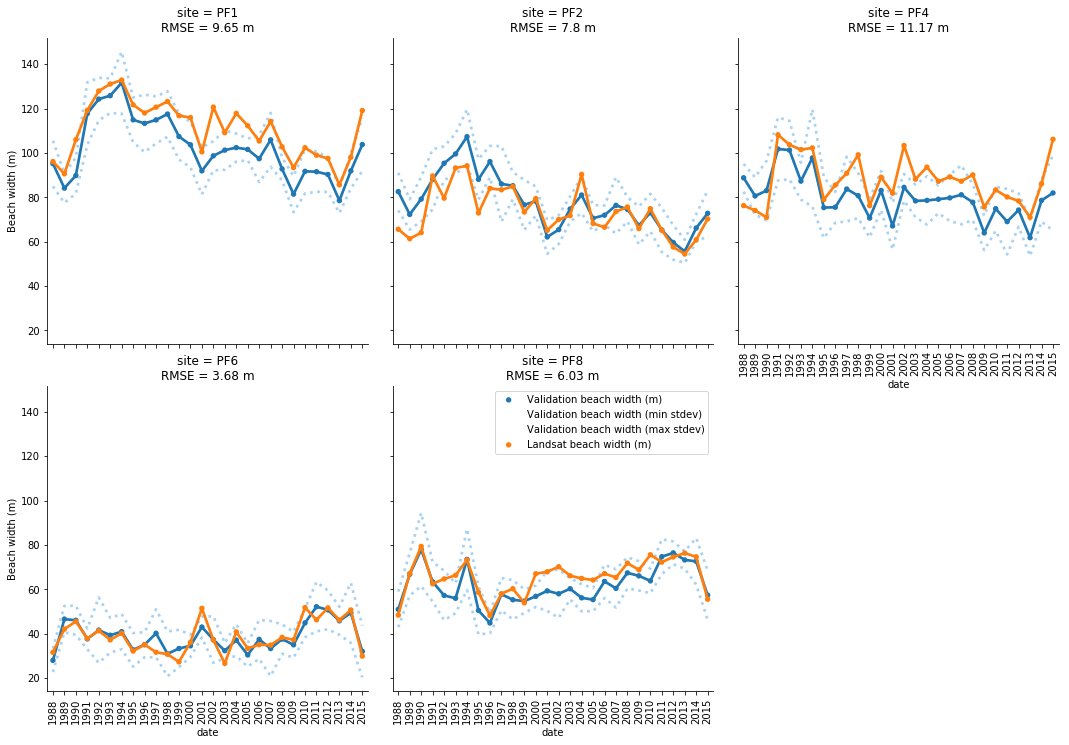

In [842]:
combined_df_wide = pd.concat(out_list).reset_index()
combined_df_wide['Validation beach width (min stdev)'] = combined_df_wide['Validation beach width (m)'] - combined_df_wide['Validation beach width (stdev)']
combined_df_wide['Validation beach width (max stdev)'] = combined_df_wide['Validation beach width (m)'] + combined_df_wide['Validation beach width (stdev)']
combined_df_wide =  combined_df_wide.drop(['Validation beach width (stdev)'], axis=1)
combined_df_wide = combined_df_wide.iloc[:, [0, 1, 5, 6, 2, 3, 4]]

combined_df = pd.melt(combined_df_wide, id_vars=['site', 'date', 'RMSE'], value_name='Beach width (m)')
g = sns.catplot(data=combined_df, x='date', y='Beach width (m)', hue='variable', col='site', kind='point', legend=False, col_wrap=3, 
                palette=['#1f77b4', '#a8d2f0', '#a8d2f0', '#ff7f0e'], markers=[".", "", "", "."], linestyles=['-', ':', ':', '-'])
g.set_xticklabels(rotation=90)

axes = g.axes.flatten()
for i, ax in enumerate(axes):
    current_title = ax.get_title()
    current_rmse = np.round(combined_df.groupby('site').RMSE.max()[i], 2)
    ax.set_title(f'{current_title}\nRMSE = {np.round(current_rmse, 2)} m')
plt.legend(loc='upper right')


8.107994662611711
LinregressResult(slope=1.0581323097801114, intercept=-1.003151907085197, rvalue=0.9589824582678003, pvalue=1.9685415981554e-77, stderr=0.026625014760133632)


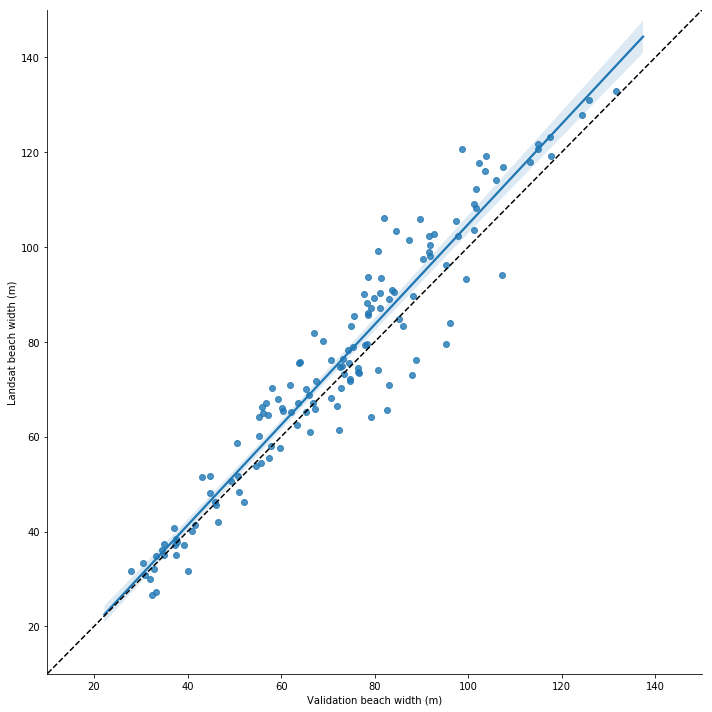

In [837]:
sns.lmplot(data=combined_df_wide, x='Validation beach width (m)', y='Landsat beach width (m)', height=10, aspect=1.0)
plt.plot(np.linspace(0, 150), np.linspace(0, 150), 'black', linestyle='dashed')
plt.ylim([10,150])
plt.xlim([10,150])

print(((combined_df_wide['Validation beach width (m)'] - combined_df_wide['Landsat beach width (m)']) ** 2).mean() ** .5)
import scipy.stats
print(scipy.stats.linregress(combined_df_wide['Validation beach width (m)'], combined_df_wide['Landsat beach width (m)']))

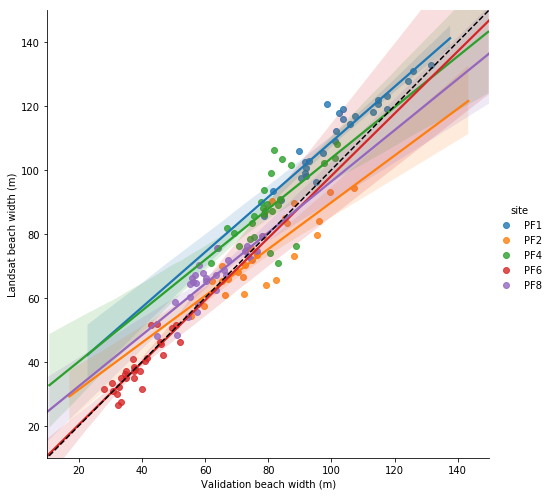

In [838]:
sns.lmplot(data=combined_df_wide, x='Validation beach width (m)', y='Landsat beach width (m)',hue='site', height=7, aspect=1.0)
plt.plot(np.linspace(0, 150), np.linspace(0, 150), 'black', linestyle='dashed')
plt.ylim([10,150]); plt.xlim([10,150]);
